In [3]:
# Import Base libs for read and show data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 
import pathlib as path
from datasets import load_dataset

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# const values
BASE_DIR = path.PosixPath('train.csv')

In [5]:
# Load dataset from CSV file
dataset_t = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')['train'].to_pandas()
dataset_v = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')['validation'].to_pandas()

In [6]:
# Visualize some dataset entry
dataset_t.head(n=10)

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive
5,http://www.wikidata.org/entity/Q104414508,100 percent corner,term for city center,concept,geography,city,cultural agnostic
6,http://www.wikidata.org/entity/Q3008535,1889 Apia cyclone,Category 1 South Pacific cyclone in 1889,entity,history,historical event,cultural agnostic
7,http://www.wikidata.org/entity/Q85720601,18th Abduction,novel by James patterson,entity,books,book,cultural agnostic
8,http://www.wikidata.org/entity/Q105570,20 July plot,"attempt to assassinate Adolf Hitler, 1944",entity,history,historical event,cultural exclusive
9,http://www.wikidata.org/entity/Q434841,20th Century Studios,American film studio owned by The Walt Disney ...,entity,media,film studio,cultural representative


In [8]:
# Plot values distribution to observer particular carachteristics
# test dataset
category_dist_t = pd.Series.value_counts((dataset_t['category']))
type_dist_t = pd.Series.value_counts((dataset_t['type']))
sub_dist_t = pd.Series.value_counts((dataset_t['subcategory']))
label_dist_t = pd.Series.value_counts((dataset_t['label']))
# validation dataset
category_dist_v = pd.Series.value_counts((dataset_v['category']))
type_dist_v = pd.Series.value_counts((dataset_v['type']))
sub_dist_v = pd.Series.value_counts((dataset_v['subcategory']))
label_dist_v = pd.Series.value_counts((dataset_v['label']))

print(label_dist_t)

# Gaussian distribution
print(sub_dist_t)

# unbalanced
print(type_dist_t)

# category
print(category_dist_t)


label
cultural exclusive         2691
cultural agnostic          1872
cultural representative    1688
Name: count, dtype: int64
subcategory
politician           99
film                 95
law                  95
sport                95
ritual               94
                     ..
environment           5
cooking technique     4
fashion trend         4
writing style         4
body language         1
Name: count, Length: 108, dtype: int64
type
entity     3924
concept    2327
Name: count, dtype: int64
category
politics                   532
sports                     429
geography                  411
architecture               396
philosophy and religion    395
literature                 363
music                      348
food                       346
fashion                    319
visual arts                313
comics and anime           312
history                    304
biology                    286
media                      285
performing arts            275
films               

## Category Analysis

Look up to exploit some information on category, analyzing statistical aspects such as data distribution

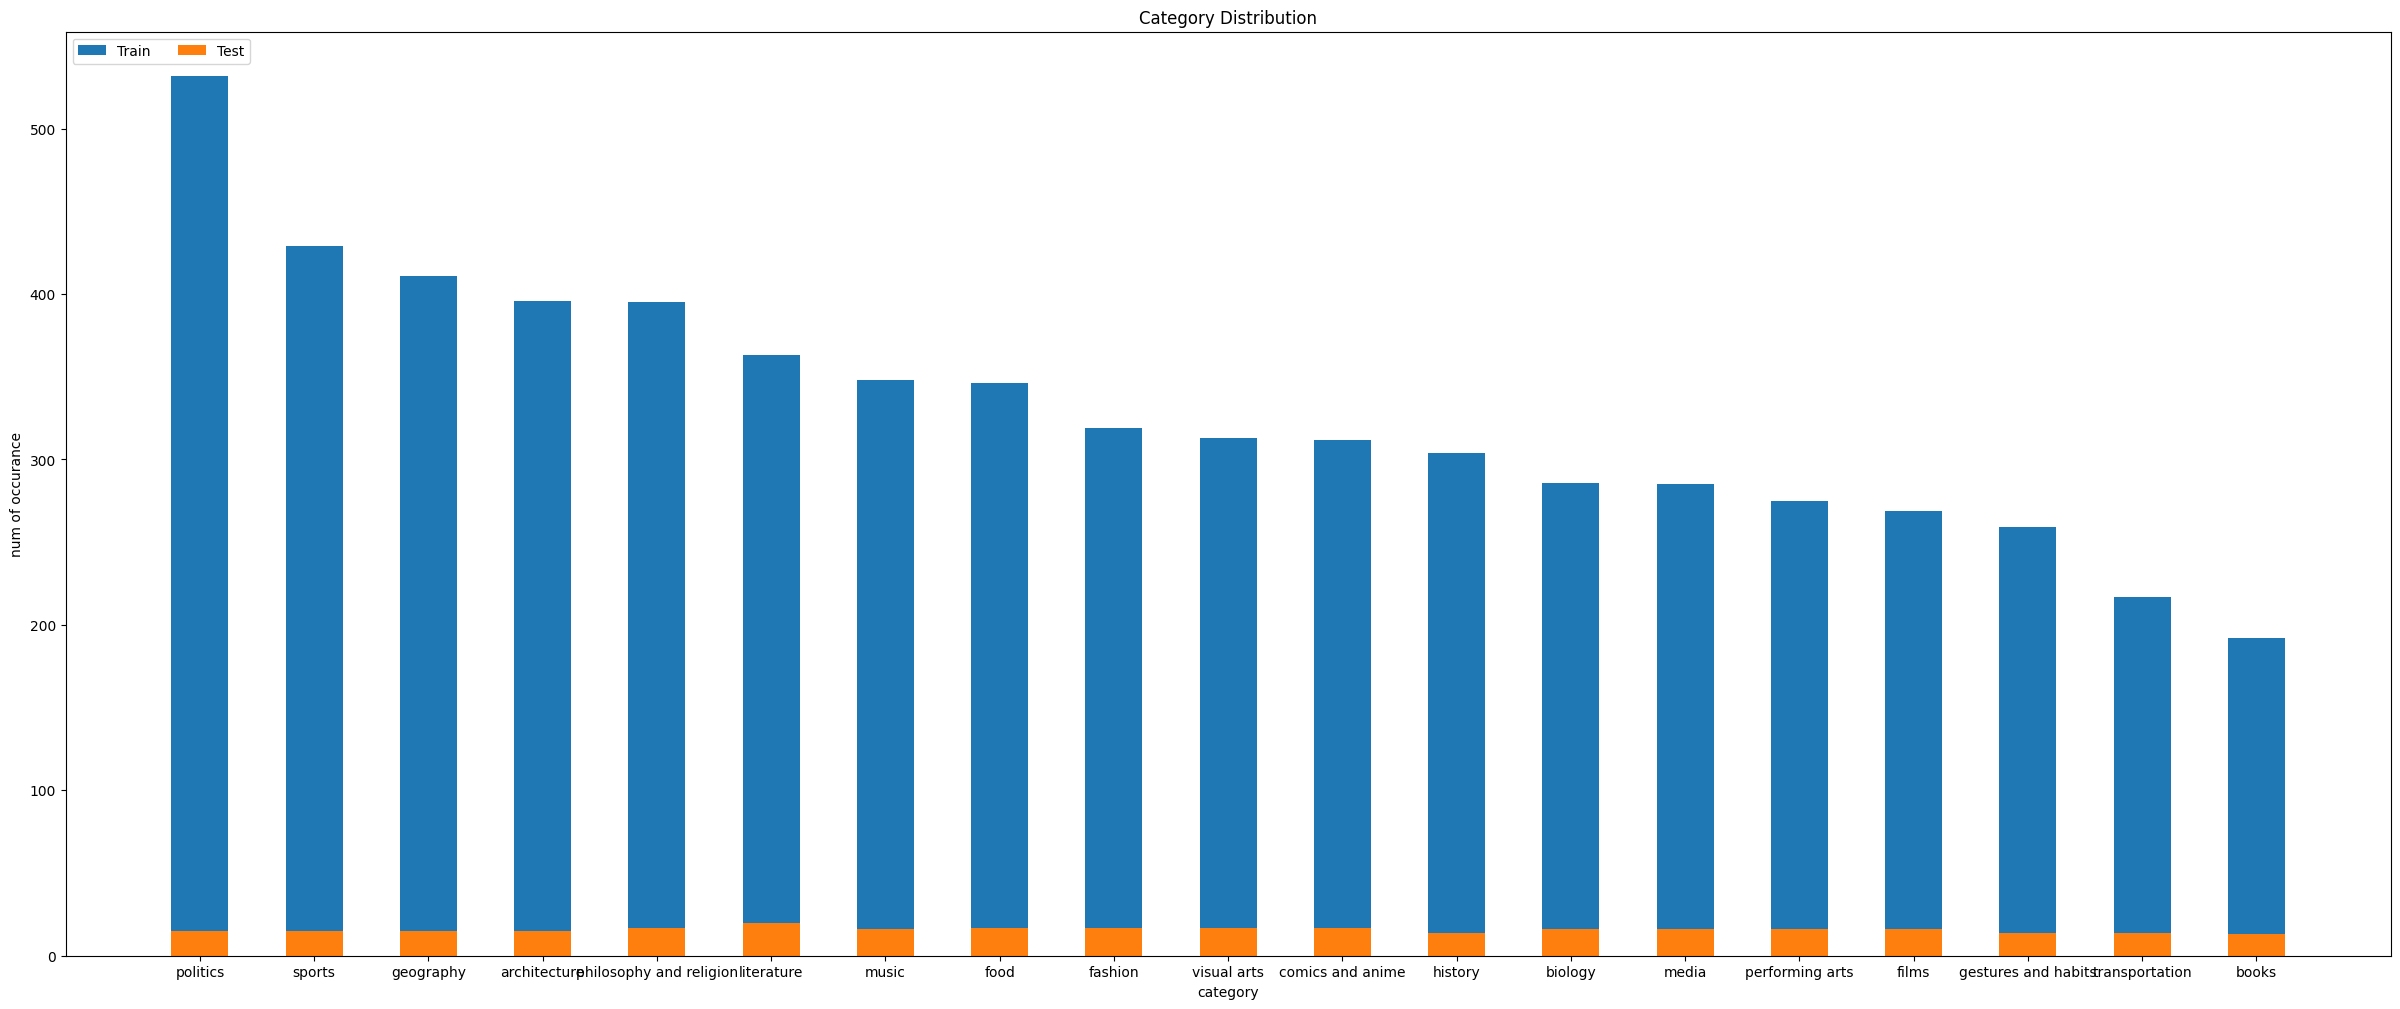

In [9]:
# Plots category distribution
plt.figure(figsize=(30,12))
plt.title('Category Distribution')
plt.xlabel('category')
plt.ylabel('num of occurance')
plt.bar(category_dist_t.index, category_dist_t, 0.5, label='Train')

plt.bar(category_dist_v.index, category_dist_v, 0.5, label='Test')
plt.legend(loc='upper left', ncols=2)

## Subcategory Analysis

Look up to exploit some information on category analyzing statistical aspects, such as data distribution and visual rappresentation

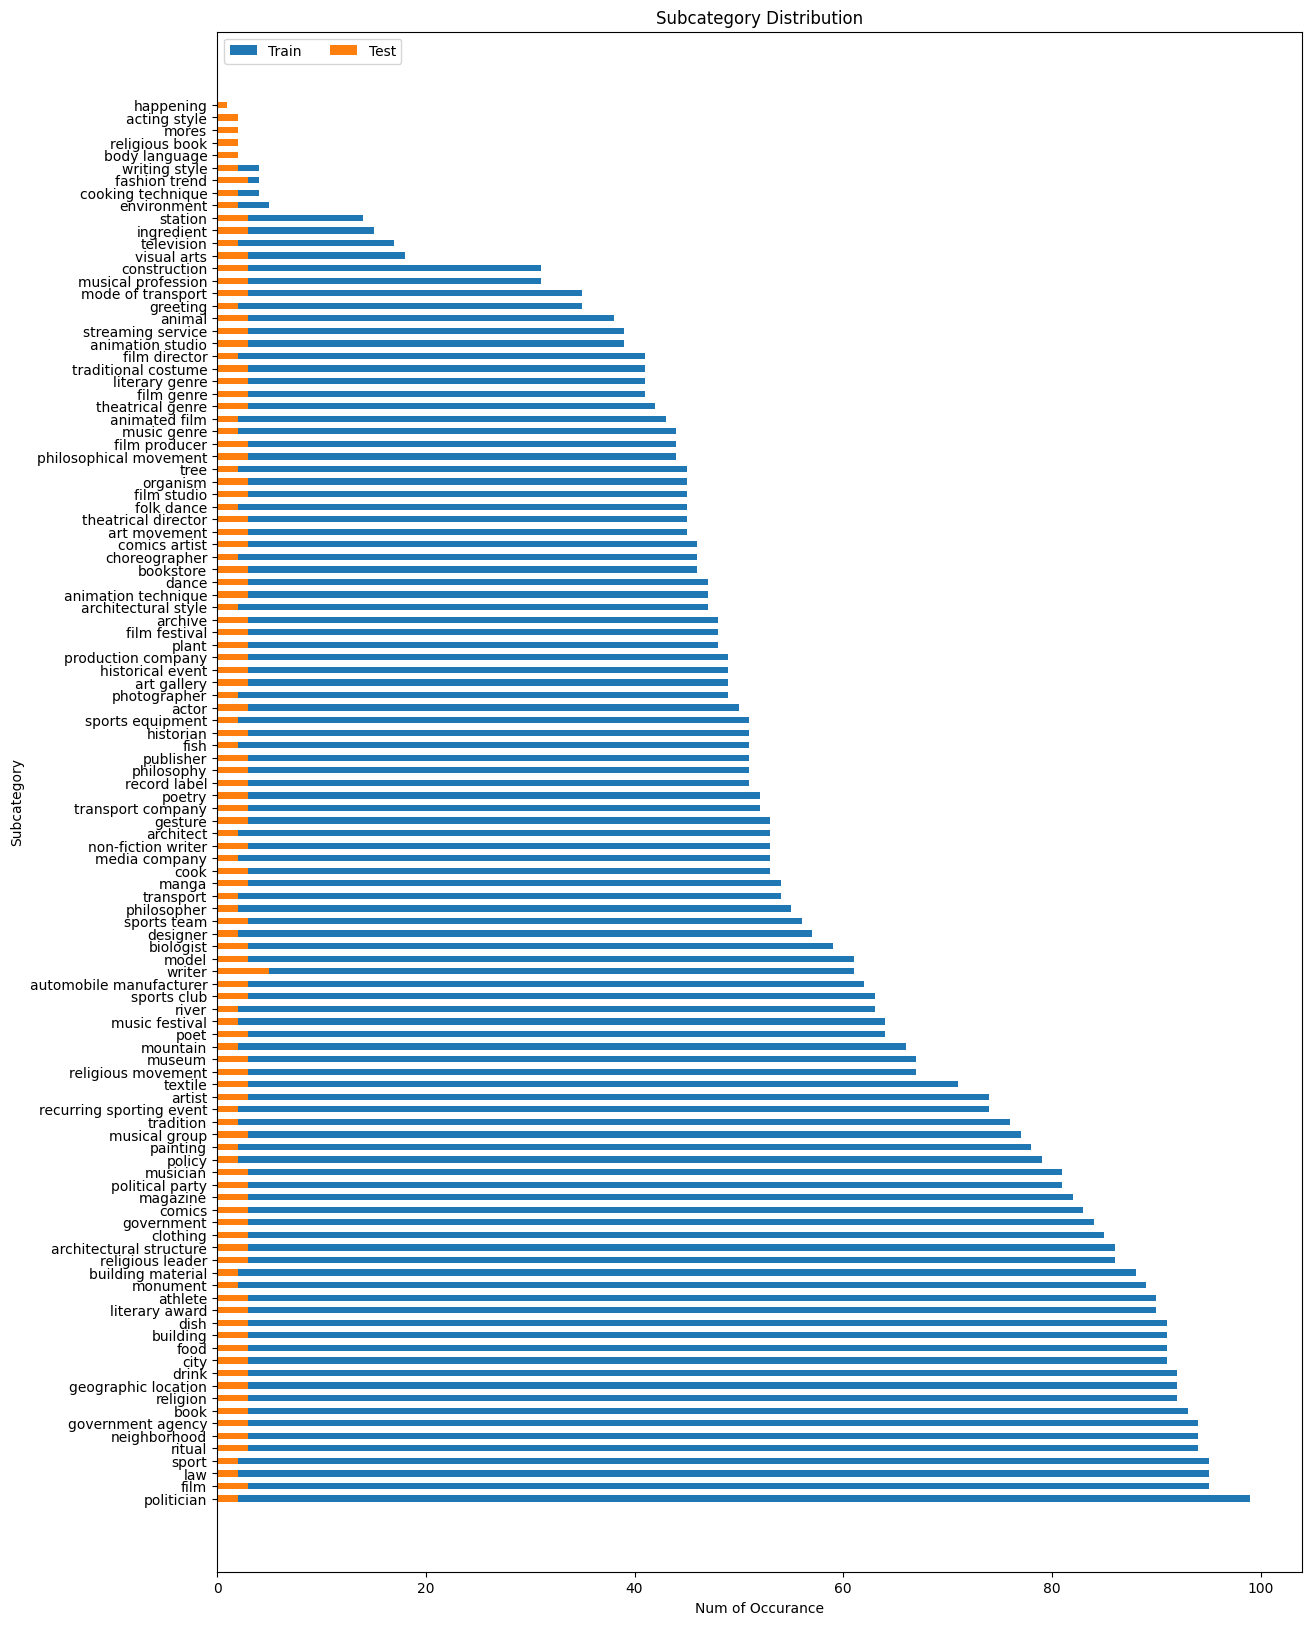

In [9]:
# Plots category distribution

plt.figure(figsize=(14,20))
plt.title('Subcategory Distribution')
plt.ylabel('Subcategory')
plt.xlabel('Num of Occurance')
plt.barh(sub_dist_t.index, sub_dist_t, 0.5, label='Train')
plt.barh(sub_dist_v.index, sub_dist_v, 0.5, label='Test')
plt.legend(loc='upper left', ncols=2)

## Labels Analysis

Check the number of classes to identify, this analysis is useful to find unbalanced data factor

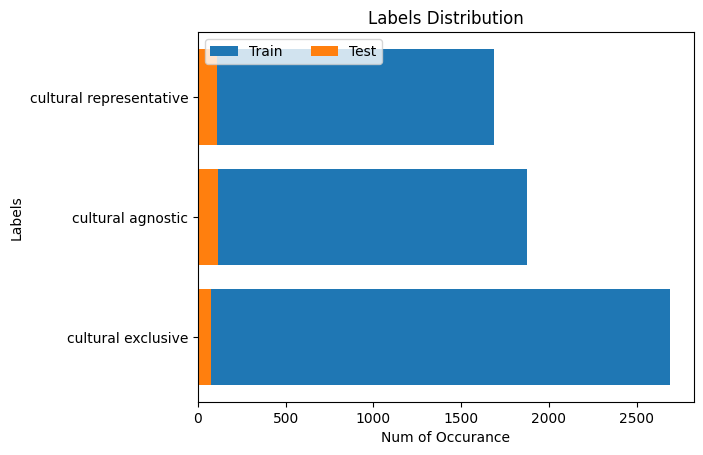

In [10]:
# Plots category distribution

plt.figure()
plt.title('Labels Distribution')
plt.ylabel('Labels')
plt.xlabel('Num of Occurance')
plt.barh(label_dist_t.index, label_dist_t, label='Train')
plt.barh(label_dist_v.index, label_dist_v, label='Test')
plt.legend(loc='upper left', ncols=2)

## Type Analysis

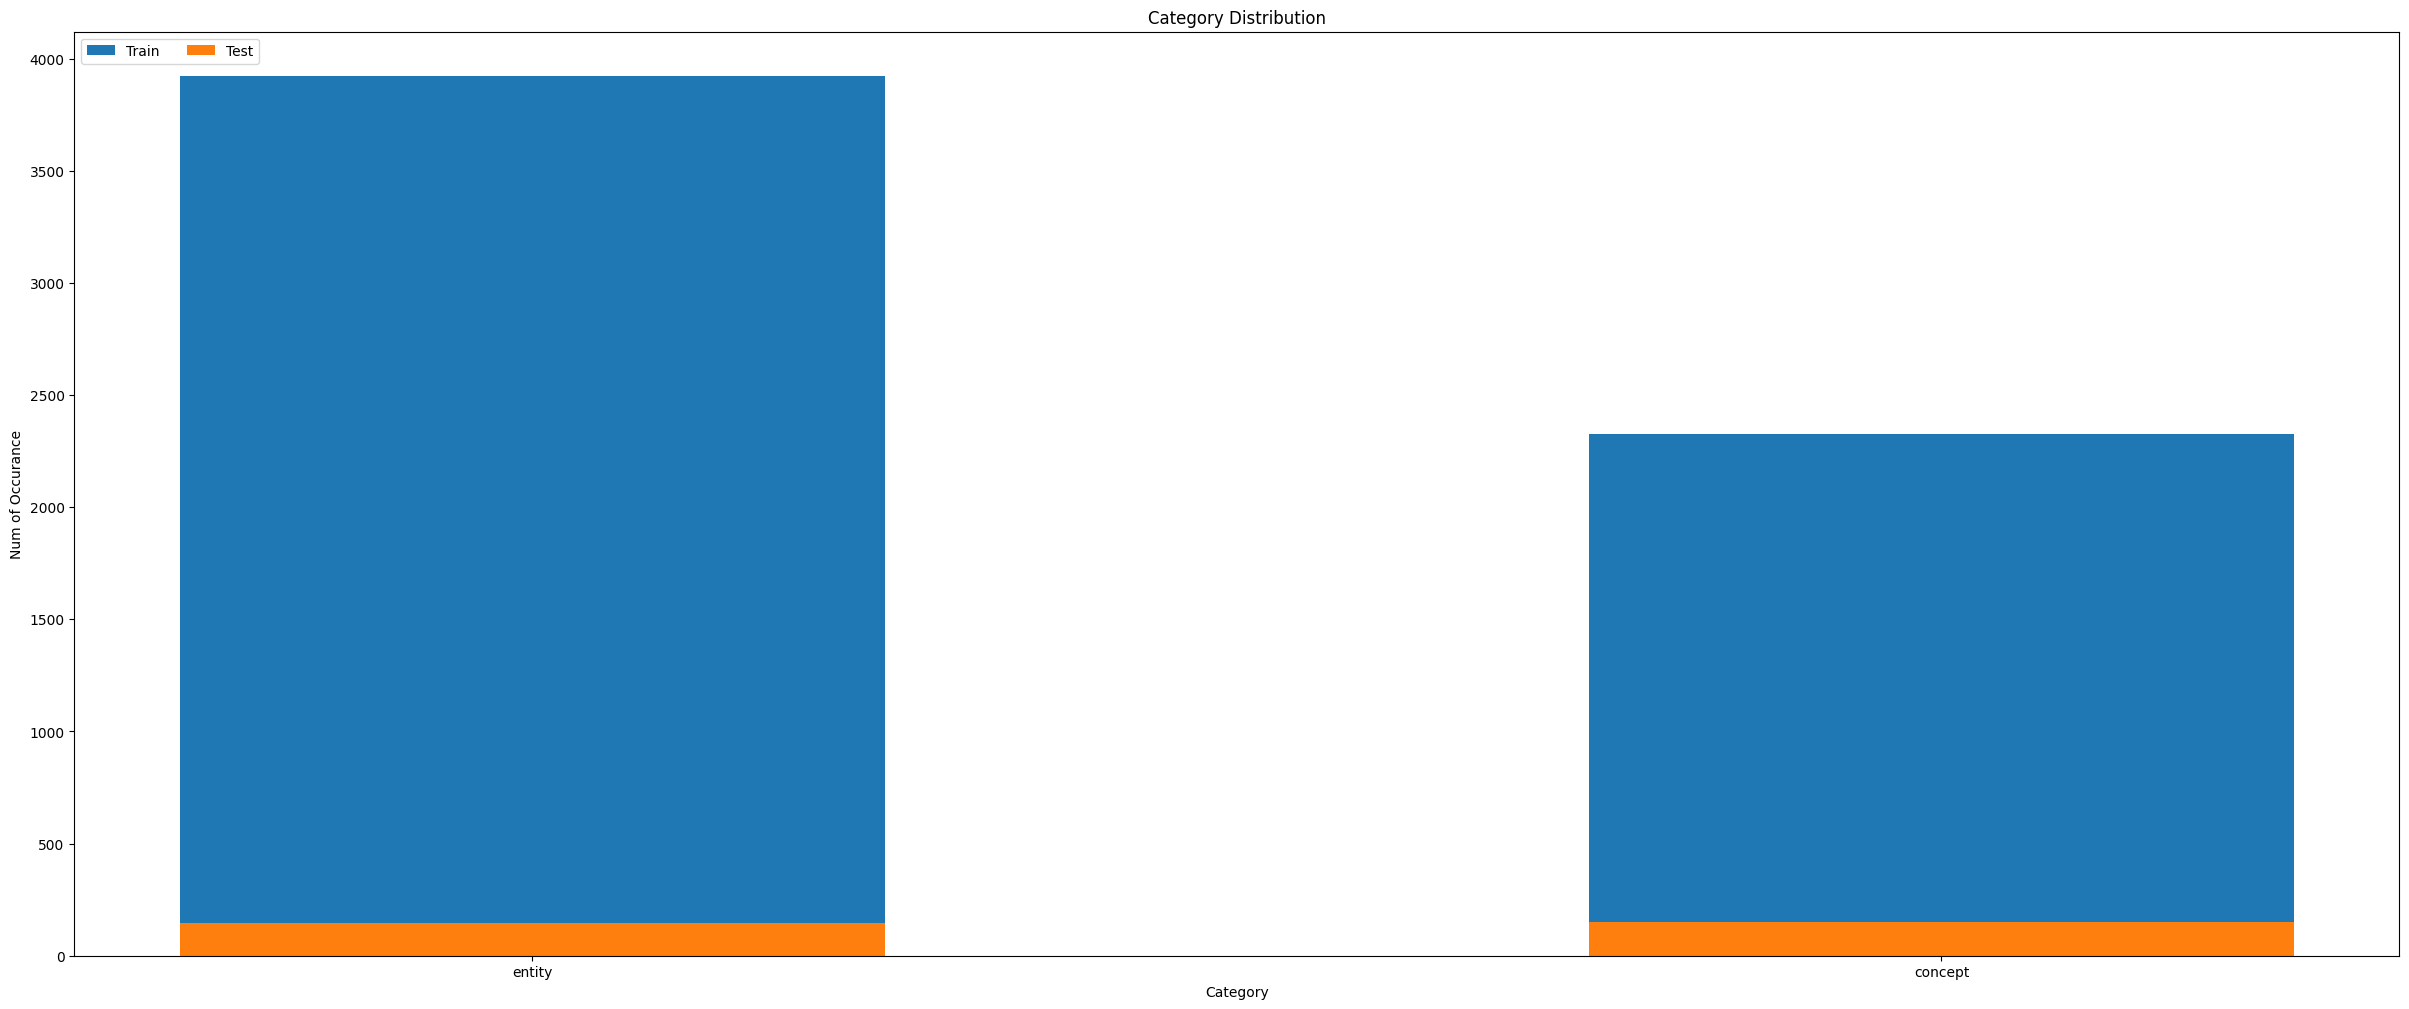

In [13]:
# Plots category distribution
plt.figure(figsize=(30,12))
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Num of Occurance')
plt.bar(type_dist_t.index, type_dist_t, 0.5, label='Train')
plt.bar(type_dist_v.index, type_dist_v, 0.5, label='Test')
plt.legend(loc='upper left', ncols=2)

## Languages Analysis

In [ ]:
#TODO

## Links Analysis

In [ ]:
#TODO

## Hyperlinks Modelling

In [ ]:
#TODO

[('Rome', {'count': 0}), ('14 regions of Augustan Rome', {})]


KeyError: 'count'